In [1]:
import matplotlib.pyplot as plt
import numpy as np
import midii
import copy
from pathlib import Path

In [2]:
mid = midii.MidiFile(
    midii.sample.dataset[0], convert_1_to_0=True, lyric_encoding="cp949"
)
Path(mid.filename).name

'ba_05688_-4_a_s02_m_02.mid'

In [3]:
def calculate_absolute_times(delta_times):
    """Calculates absolute times from delta times."""
    return np.cumsum(np.array(delta_times, dtype=np.int64))

In [4]:
# --- Generate Data for Plotting ---
original_abs_times = calculate_absolute_times(mid.times)

mid_quant_wo_ef = copy.deepcopy(mid)
mid_quant_wo_ef .quantize(error_forwarding=False)
quantized_abs_times_naive = calculate_absolute_times(mid_quant_wo_ef.times)

mid_quant_w_ef = copy.deepcopy(mid)
mid_quant_w_ef.quantize()
quantized_abs_times_with_EF = calculate_absolute_times(mid_quant_w_ef.times)

# Calculate drift (deviation from original absolute time)
drift_naive = quantized_abs_times_naive - original_abs_times
drift_with_EF = quantized_abs_times_with_EF - original_abs_times

# Use event index as x-axis for simplicity
event_index = np.arange(len(mid.times))

In [5]:
subset = slice(0, 500, 1)
drift_naive = drift_naive[subset]
drift_with_EF = drift_with_EF[subset] 
event_index = event_index[subset] 

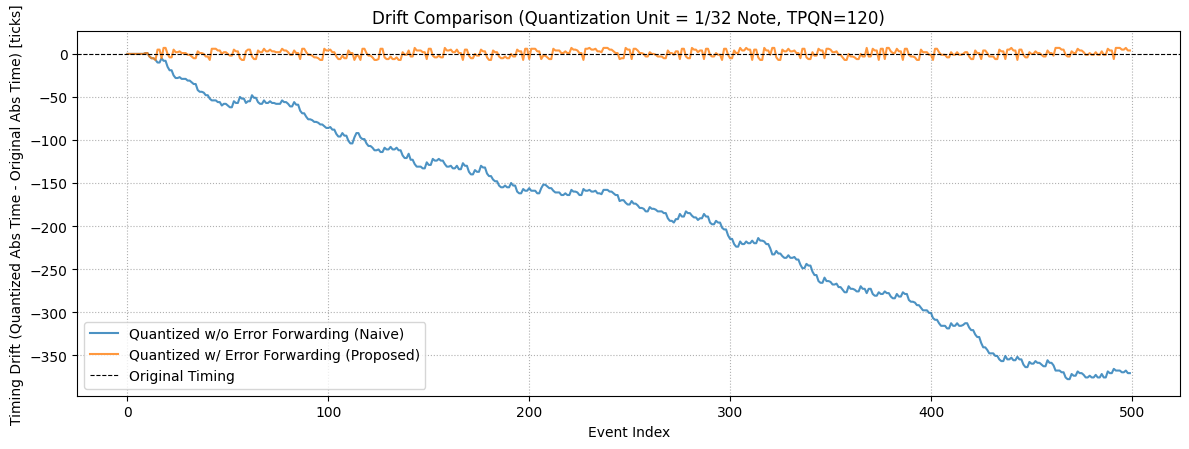

In [6]:
fig, ax = plt.subplots(figsize=(12, 5))
# fig.suptitle('Figure 3: Absolute Timing Drift Comparison', fontsize=14)

ax.plot(event_index, drift_naive, label='Quantized w/o Error Forwarding (Naive)', alpha=0.8, linewidth=1.5)
ax.plot(event_index, drift_with_EF, label='Quantized w/ Error Forwarding (Proposed)', alpha=0.8, linewidth=1.5)

ax.axhline(0, color='black', linestyle='--', linewidth=0.8, label='Original Timing')
ax.set_xlabel("Event Index")
ax.set_ylabel("Timing Drift (Quantized Abs Time - Original Abs Time) [ticks]")
ax.set_title(f"Drift Comparison (Quantization Unit = 1/{int(4/0.125)} Note, TPQN={mid.ticks_per_beat})")
ax.grid(True, linestyle=':')
ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("../figure/figure_EF_w_wo_comparison.pdf", format="pdf", bbox_inches='tight') 
# plt.show() # Use plt.savefig('figure3_drift_comparison.png', dpi=300) for paper

In [44]:
abs_time = sum(mid.times)
abs_time_quant_w_ef = sum(mid_quant_w_ef.times)
abs_time_quant_wo_ef = sum(mid_quant_wo_ef.times)
print(abs_time, abs_time_quant_w_ef, abs_time_quant_wo_ef)
print(f"Final accumulated error(w EF)={abs(abs_time - abs_time_quant_w_ef)}")
print(f"Final accumulated error(wo EF)={abs(abs_time - abs_time_quant_wo_ef)}")

32640 32636 31984
Final accumulated error(w EF)=4
Final accumulated error(wo EF)=656


In [56]:
abs_times = np.cumsum(mid.times)
abs_times_quant_w_ef = np.cumsum(mid_quant_w_ef.times)
abs_times_quant_wo_ef = np.cumsum(mid_quant_wo_ef.times)
MAE_w_ef = np.mean(abs(abs_times - abs_times_quant_w_ef))
MAE_wo_ef = np.mean(abs(abs_times - abs_times_quant_wo_ef))
print(f"Mean Absolute Error(w EF)={MAE_w_ef:.2f}")
print(f"Mean Absolute Error(wo EF)={MAE_wo_ef:.2f}")

Mean Absolute Error(w EF)=3.67
Mean Absolute Error(wo EF)=343.52


In [57]:
RMSE_w_ef = np.mean(np.square(abs_times - abs_times_quant_w_ef))
RMSE_wo_ef = np.mean(np.square(abs_times - abs_times_quant_wo_ef))
print(f"Root Mean Square Error(w EF)={RMSE_w_ef:.2f}")
print(f"Root Mean Square Error(wo EF)={RMSE_wo_ef:.2f}")

Root Mean Square Error(w EF)=17.94
Root Mean Square Error(wo EF)=155626.83
